In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data.csv')
columns = list(df.columns)
df.shape

(288, 7)

In [3]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []

        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        # print(clusters_range)
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            # print(labels)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
#         plt.plot(silhouette_range[:], silhouette_scores[:], label = title)
#         plt.xlabel('Number of Clusters')
#         plt.ylabel('Silhouette Score')
#         plt.title(title)
#         plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
#         plt.savefig(folder + 'silhouette_'+ save_graph_name +'.png')
#         plt.show()
#         plt.close() 
        max_score = max(silhouette_scores)
#         print(results_dict)
        for i in results_dict:
            if i[1] == max_score:
                print("The highest silhouette scores(" + str(max_score) + ") is for " + str(i[0]) + " clusers")
#                 print(f'{max_score}')
                return int(i[0])
    else:
        print('couldnt get the scores, plz help')
        print('returning number of clusters = ' + str(n_clusters_min))
#         model_cpy = copy.deepcopy(model)
#         model_cpy.set_params(n_clusters=2)

#         model_cpy.partial_fit()
#         labels = model_cpy.predict(test_data)
#         s = metrics.silhouette_score(test_data, labels, metric='euclidean')
#         print(s)
#         print('\n')
        return n_clusters_min

In [4]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#         print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

# the whole two days

In [5]:
indexes = np.array_split(df.index,16, axis=0)
for i,index in enumerate(indexes):
    df.loc[index,'group'] = i
    
df['c'] = df['group'].diff()
df_filtered = df[df['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

len(list_of_dfs)

16


[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270]


16

In [6]:
##########################################################
###############     THRESHOLD 0.01       #################
##########################################################


model_001_whole = Birch(n_clusters=None, threshold=0.01)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_001_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.01')
n = plot_silhouette_scores(model_001_whole, new_nmpy[:, :-2], 3, 10, 'threshold 0.2')
model_001_whole.set_params(n_clusters = n)
model_001_whole.partial_fit()
print('\n')

lablels_001 = model_001_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.05      #################
##########################################################


model_005_whole = Birch(n_clusters=None, threshold=0.05)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_005_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.05')
n = plot_silhouette_scores(model_005_whole, new_nmpy[:, :-2], 3, 10, 'threshold 0.2')
model_005_whole.set_params(n_clusters = n)
model_005_whole.partial_fit()
print('\n')
lablels_005 = model_005_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.1       #################
##########################################################


model_01_whole = Birch(n_clusters=None, threshold=0.1)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_01_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.1')
n = plot_silhouette_scores(model_01_whole, new_nmpy[:, :-2], 3, 10, 'threshold 0.2')
model_01_whole.set_params(n_clusters = n)
model_01_whole.partial_fit()
print('\n')

lablels_01 = model_01_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.2       #################
##########################################################


model_02_whole = Birch(n_clusters=None, threshold=0.2)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_02_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.2')
n = plot_silhouette_scores(model_02_whole, new_nmpy[:, :-2], 3, 10, 'threshold 0.2')
model_02_whole.set_params(n_clusters = n)
model_02_whole.partial_fit()
print('\n')

lablels_02 = model_02_whole.predict(new_nmpy[:, :-2])


##########################################################
###############     THRESHOLD 0.3      #################
##########################################################



model_03_whole = Birch(n_clusters=None, threshold=0.3)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_03_whole.partial_fit(numpy_array[:, :-2])
    
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
print('THRESHOLD 0.3')
n = plot_silhouette_scores(model_03_whole, new_nmpy[:, :-2], 3, 10, 'threshold 0.3')
model_03_whole.set_params(n_clusters = n)
model_03_whole.partial_fit()
print('\n')

lablels_03 = model_03_whole.predict(new_nmpy[:, :-2])

##########################################################
###############     THRESHOLD 0.5      #################
##########################################################

model_05_whole = Birch(n_clusters=None, threshold=0.5)
list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}

# add_data_to_this = pd.DataFrame(columns = columns)
for i in list_of_dfs:
    numpy_array = outliers_removal(i)
    removed_outliers_numpy.append(numpy_array)
    model_05_whole.partial_fit(numpy_array[:, :-2])
    
print('THRESHOLD 0.5')
new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
n = plot_silhouette_scores(model_05_whole, new_nmpy[:, :-2], 3 , 10, 'threshold 0.5')
model_05_whole.set_params(n_clusters = n)
model_05_whole.partial_fit()
print('\n')

lablels_05 = model_05_whole.predict(new_nmpy[:, :-2])

THRESHOLD 0.01
The highest silhouette scores(0.768694024042753) is for 3 clusers


THRESHOLD 0.05


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


The highest silhouette scores(0.768694024042753) is for 3 clusers


THRESHOLD 0.1
The highest silhouette scores(0.768694024042753) is for 3 clusers


THRESHOLD 0.2
The highest silhouette scores(0.768694024042753) is for 3 clusers


THRESHOLD 0.3


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


The highest silhouette scores(0.7610447043039985) is for 3 clusers


THRESHOLD 0.5
The highest silhouette scores(0.768694024042753) is for 3 clusers




/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


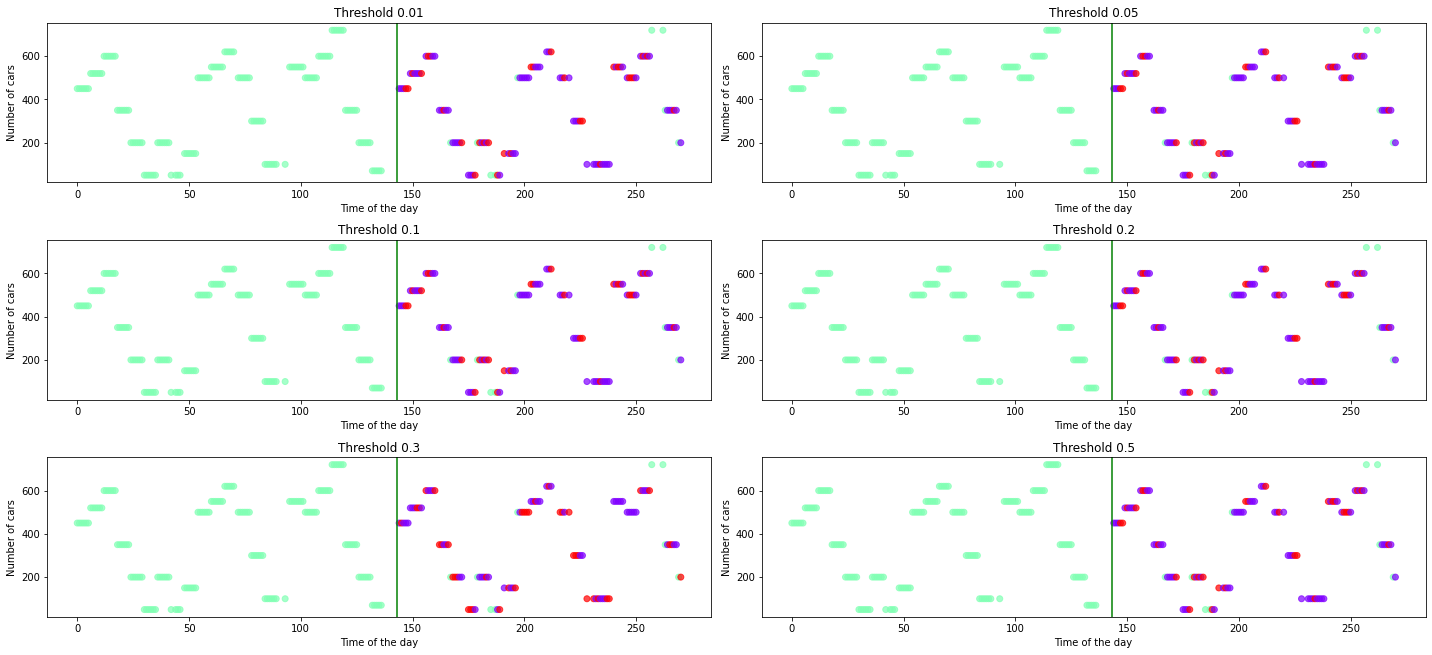

In [9]:
figure, axs = plt.subplots(nrows=3, ncols=2,figsize=(20,10))

axs[0,0].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_001, cmap='rainbow', alpha=0.7)
axs[0,0].axvline(x=143, color='g')
axs[0,0].set_ylabel('Number of cars')
axs[0,0].set_xlabel('Time of the day')
axs[0,0].title.set_text("Threshold 0.01")

axs[0,1].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_005, cmap='rainbow', alpha=0.7)
axs[0,1].axvline(x=143, color='g')
axs[0,1].set_ylabel('Number of cars')
axs[0,1].set_xlabel('Time of the day')
axs[0,1].title.set_text("Threshold 0.05")

axs[1,0].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_01, cmap='rainbow', alpha=0.7) 
axs[1,0].axvline(x=143, color='g')
axs[1,0].set_ylabel('Number of cars')
axs[1,0].set_xlabel('Time of the day')
axs[1,0].title.set_text("Threshold 0.1")

axs[1,1].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_02, cmap='rainbow', alpha=0.7)  
axs[1,1].axvline(x=143, color='g')
axs[1,1].set_ylabel('Number of cars')
axs[1,1].set_xlabel('Time of the day')
axs[1,1].title.set_text("Threshold 0.2")

axs[2,0].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_03, cmap='rainbow', alpha=0.7)
axs[2,0].axvline(x=143, color='g')
axs[2,0].set_ylabel('Number of cars')
axs[2,0].set_xlabel('Time of the day')
axs[2,0].title.set_text("Threshold 0.3")

axs[2,1].scatter(new_nmpy[:,5], new_nmpy[:,4], c=lablels_05, cmap='rainbow', alpha=0.7)
axs[2,1].axvline(x=143, color='g')
axs[2,1].set_ylabel('Number of cars')
axs[2,1].set_xlabel('Time of the day')
axs[2,1].title.set_text("Threshold 0.5")

figure.tight_layout(rect=[0, 0.03, 1, 0.95])

# pick threshold with best score and depict a run of it

couldnt get the scores, plz help
returning number of clusters = 3
couldnt get the scores, plz help
returning number of clusters = 3
couldnt get the scores, plz help
returning number of clusters = 3
The highest silhouette scores(0.48567808477721214) is for 3 clusers
The highest silhouette scores(0.476123994180306) is for 3 clusers
The highest silhouette scores(0.6000997739297432) is for 3 clusers
The highest silhouette scores(0.5804631546833591) is for 3 clusers
The highest silhouette scores(0.608683272566021) is for 3 clusers
The highest silhouette scores(0.9103442145562338) is for 3 clusers
The highest silhouette scores(0.8695012586574994) is for 3 clusers
The highest silhouette scores(0.8149255333539238) is for 3 clusers
The highest silhouette scores(0.8220368520622181) is for 3 clusers


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (1) by Birch is less than (3). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)
/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/cluster/_birch.py:638: ConvergenceWarning

The highest silhouette scores(0.8036487198644938) is for 3 clusers
The highest silhouette scores(0.7773136095881104) is for 3 clusers
The highest silhouette scores(0.7690260221219769) is for 3 clusers
The highest silhouette scores(0.768694024042753) is for 3 clusers


/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


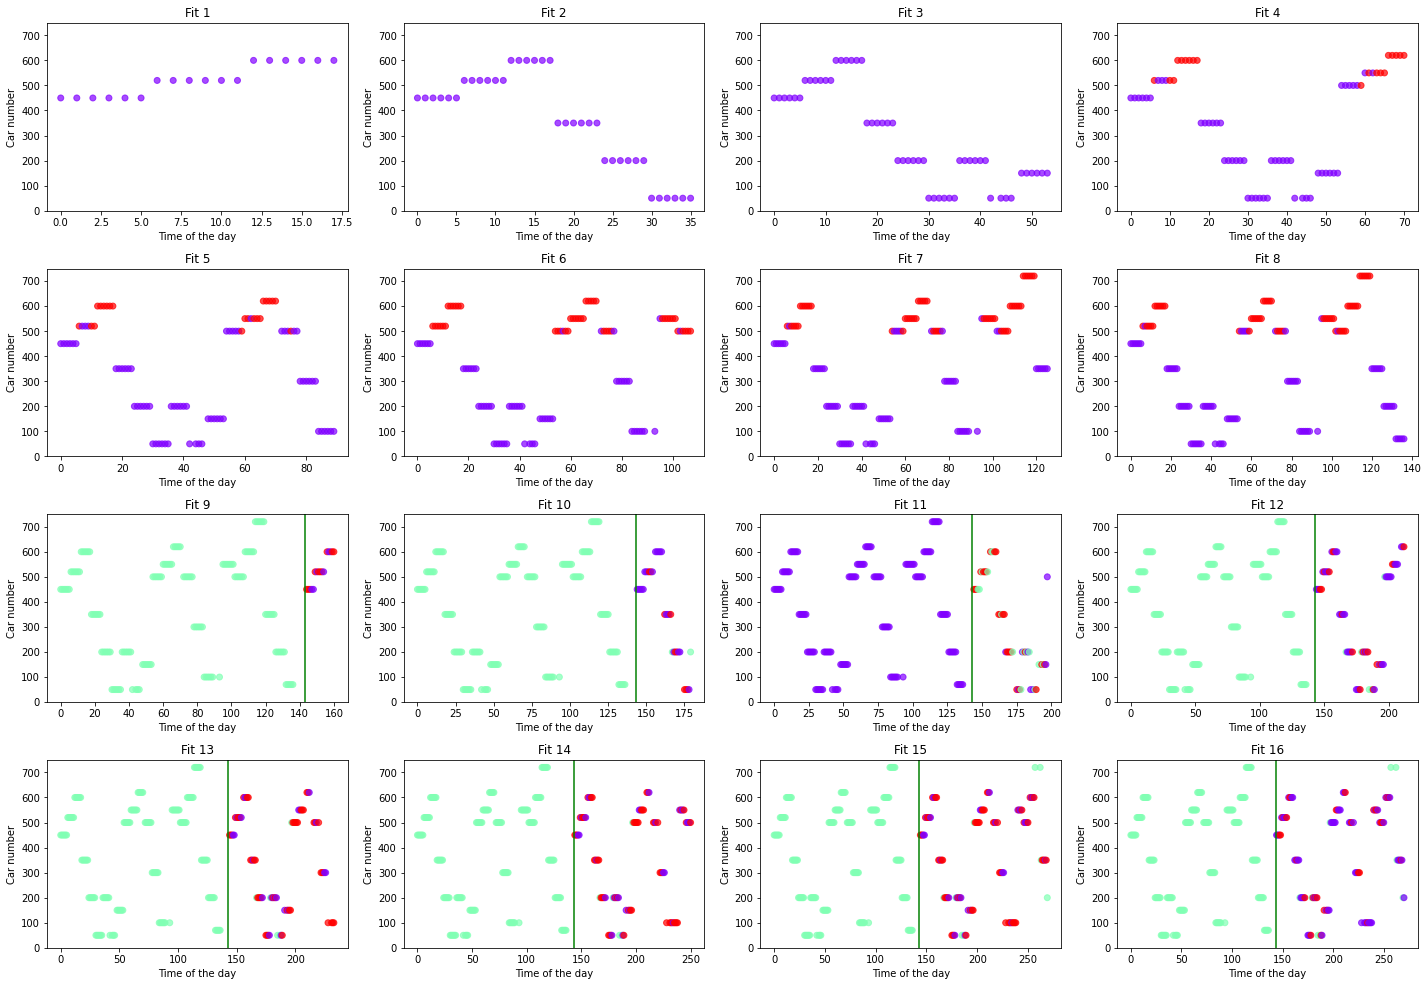

In [10]:
model_03_before= Birch(n_clusters=None, threshold=0.5)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

for i in range(0, len(list_of_dfs)):
#     add_data_to_this = pd.concat([add_data_to_this, i])
    
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_03_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_03_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 3, 10, 'threshold 0.05')
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

    
    
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 4
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,15))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1